# Binary-Class Tabular Model for Kaggle Playground Series Season 3 Episode 2 Using Python and Scikit-Learn
### David Lowe
### January 23, 2023

SUMMARY: The project aims to construct a predictive model using various machine learning algorithms and document the end-to-end steps using a template. The Kaggle Playground Series Season 3 Episode 2 dataset is a binary-class modeling situation where we attempt to predict one of two possible outcomes.

INTRODUCTION: Kaggle wants to provide an approachable environment for relatively new people in their data science journey. Since January 2021, they have hosted playground-style competitions to give the Kaggle community a variety of reasonably lightweight challenges that can be used to learn and sharpen skills in different aspects of machine learning and data science. The dataset for this competition was generated from a deep learning model trained on the Stroke Prediction Dataset. Feature distributions are close to but different from the original.

ANALYSIS: The average performance of the machine learning algorithms achieved an AUC/ROC benchmark of 0.7836 after training. Furthermore, we selected Logistic Regression as the final model as it processed the training dataset with an AUC/ROC score of 0.8735. When we processed the test dataset with the final model, the model achieved an AUC/ROC score of 0.8670.

CONCLUSION: In this iteration, the Logistic Regression model appeared to be a suitable algorithm for modeling this dataset.

Dataset Used: Playground Series Season 3, Episode 2

Dataset ML Model: Binary-Class classification with numerical and categorical features

Dataset Reference: https://www.kaggle.com/competitions/playground-series-s3e2

One source of potential performance benchmarks: https://www.kaggle.com/competitions/playground-series-s3e2/leaderboard

## Task 1 - Prepare Environment

In [1]:
# Retrieve the CPU information
ncpu = !nproc
print("The number of available CPUs is:", ncpu[0])

The number of available CPUs is: 2


### 1.a) Load libraries and modules

In [2]:
# Set the random seed number for reproducible results
RNG_SEED = 888

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import sys
import math
# import boto3
import zipfile
import urllib
from datetime import datetime
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn import compose
from sklearn import impute

from sklearn.feature_selection import RFE
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

### 1.b) Set up the controlling parameters and functions

In [4]:
# Begin the timer for the script processing
START_TIME_SCRIPT = datetime.now()

# Set up the number of CPU cores available for multi-thread processing
N_JOBS = 1

# Set up the flag to stop sending progress emails (setting to True will send status emails!)
NOTIFY_STATUS = False

# Set the percentage sizes for splitting the dataset
TEST_SET_RATIO = 0.1
VAL_SET_RATIO = 0.1

# Set the name for the class/label column
ORIGINAL_LABEL = 'stroke'
CLASS_COLUMN = 'target'

# Set the number of folds for cross validation
N_FOLDS = 10

# Set default modeling scoring metric
SCORING_METRIC = 'roc_auc'

# Define the directory locations and file names
ORIGINAL_DATASET = 'https://dainesanalytics.com/datasets/kaggle-playground-series-s3e02/healthcare-dataset-stroke-data.csv'
TRAIN_DATASET = 'https://dainesanalytics.com/datasets/kaggle-playground-series-s3e02/train.csv'
TEST_DATASET = 'https://dainesanalytics.com/datasets/kaggle-playground-series-s3e02/test.csv'
SUBMISSION_TEMPLATE = 'https://dainesanalytics.com/datasets/kaggle-playground-series-s3e02/sample_submission.csv'
SUBMISSION_FILE = 'submission_sklearn_'

In [5]:
# Set up the email notification function
def status_notify(msg_text):
    access_key = os.environ.get('SNS_ACCESS_KEY')
    secret_key = os.environ.get('SNS_SECRET_KEY')
    aws_region = os.environ.get('SNS_AWS_REGION')
    topic_arn = os.environ.get('SNS_TOPIC_ARN')
    if (access_key is None) or (secret_key is None) or (aws_region is None):
        sys.exit("Incomplete notification setup info. Script Processing Aborted!!!")
    sns = boto3.client('sns', aws_access_key_id=access_key, aws_secret_access_key=secret_key, region_name=aws_region)
    response = sns.publish(TopicArn=topic_arn, Message=msg_text)
    if response['ResponseMetadata']['HTTPStatusCode'] != 200 :
        print('Status notification not OK with HTTP status code:', response['ResponseMetadata']['HTTPStatusCode'])

In [6]:
if NOTIFY_STATUS: status_notify("Task 1 - Prepare Environment has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 1.c) Load dataset

In [7]:
df_dataset_import = pd.read_csv(TRAIN_DATASET)

# Take a peek at the dataframe after import
print(df_dataset_import.head())

   id  gender   age  hypertension  heart_disease ever_married work_type  \
0   0    Male  28.0             0              0          Yes   Private   
1   1    Male  33.0             0              0          Yes   Private   
2   2  Female  42.0             0              0          Yes   Private   
3   3    Male  56.0             0              0          Yes   Private   
4   4  Female  24.0             0              0           No   Private   

  Residence_type  avg_glucose_level   bmi   smoking_status  stroke  
0          Urban              79.53  31.1     never smoked       0  
1          Rural              78.44  23.9  formerly smoked       0  
2          Rural             103.00  40.3          Unknown       0  
3          Urban              64.87  28.8     never smoked       0  
4          Rural              73.36  28.8     never smoked       0  


In [8]:
df_dataset_import.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15304 entries, 0 to 15303
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 15304 non-null  int64  
 1   gender             15304 non-null  object 
 2   age                15304 non-null  float64
 3   hypertension       15304 non-null  int64  
 4   heart_disease      15304 non-null  int64  
 5   ever_married       15304 non-null  object 
 6   work_type          15304 non-null  object 
 7   Residence_type     15304 non-null  object 
 8   avg_glucose_level  15304 non-null  float64
 9   bmi                15304 non-null  float64
 10  smoking_status     15304 non-null  object 
 11  stroke             15304 non-null  int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 1.4+ MB


In [9]:
print(df_dataset_import.describe())

                 id           age  hypertension  heart_disease  \
count  15304.000000  15304.000000  15304.000000   15304.000000   
mean    7651.500000     41.417708      0.049726       0.023327   
std     4418.028595     21.444673      0.217384       0.150946   
min        0.000000      0.080000      0.000000       0.000000   
25%     3825.750000     26.000000      0.000000       0.000000   
50%     7651.500000     43.000000      0.000000       0.000000   
75%    11477.250000     57.000000      0.000000       0.000000   
max    15303.000000     82.000000      1.000000       1.000000   

       avg_glucose_level           bmi        stroke  
count       15304.000000  15304.000000  15304.000000  
mean           89.039853     28.112721      0.041296  
std            25.476102      6.722315      0.198981  
min            55.220000     10.300000      0.000000  
25%            74.900000     23.500000      0.000000  
50%            85.120000     27.600000      0.000000  
75%            96.98

In [10]:
print(df_dataset_import.isnull().sum())
print('Total number of NaN in the dataframe: ', df_dataset_import.isnull().sum().sum())

id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64
Total number of NaN in the dataframe:  0


In [11]:
# Get grouping size for the target variable
print(df_dataset_import.groupby(ORIGINAL_LABEL).size())

stroke
0    14672
1      632
dtype: int64


### 1.d) Data Cleaning

In [12]:
# Fetch the original dataset and use it to supplement the training
df_dataset_original = pd.read_csv(ORIGINAL_DATASET)
df_dataset_original['is_synthetic'] = 0

# Take a peek at the dataframe after import
print(df_dataset_original.head())

      id  gender   age  hypertension  heart_disease ever_married  \
0   9046    Male  67.0             0              1          Yes   
1  51676  Female  61.0             0              0          Yes   
2  31112    Male  80.0             0              1          Yes   
3  60182  Female  49.0             0              0          Yes   
4   1665  Female  79.0             1              0          Yes   

       work_type Residence_type  avg_glucose_level   bmi   smoking_status  \
0        Private          Urban             228.69  36.6  formerly smoked   
1  Self-employed          Rural             202.21   NaN     never smoked   
2        Private          Rural             105.92  32.5     never smoked   
3        Private          Urban             171.23  34.4           smokes   
4  Self-employed          Rural             174.12  24.0     never smoked   

   stroke  is_synthetic  
0       1             0  
1       1             0  
2       1             0  
3       1             0 

In [13]:
df_dataset_original.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
 12  is_synthetic       5110 non-null   int64  
dtypes: float64(3), int64(5), object(5)
memory usage: 519.1+ KB


In [14]:
# Combine the original and synthetic datasets into one training dataset
df_dataset_import['is_synthetic'] = 1

df_dataset_import = pd.concat([df_dataset_import, df_dataset_original],
                              ignore_index=True)
df_dataset_import.drop(columns=['id'], inplace=True)

df_dataset_import.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20414 entries, 0 to 20413
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             20414 non-null  object 
 1   age                20414 non-null  float64
 2   hypertension       20414 non-null  int64  
 3   heart_disease      20414 non-null  int64  
 4   ever_married       20414 non-null  object 
 5   work_type          20414 non-null  object 
 6   Residence_type     20414 non-null  object 
 7   avg_glucose_level  20414 non-null  float64
 8   bmi                20213 non-null  float64
 9   smoking_status     20414 non-null  object 
 10  stroke             20414 non-null  int64  
 11  is_synthetic       20414 non-null  int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 1.9+ MB


In [15]:
def clean_gender(target_col):
    # print(target_col)
    if target_col == 'Other':
        return 'Male'
    else:
        return target_col

def clean_smoking_status(target_col):
    # print(target_col)
    if target_col == 'Unknown':
        return 'never smoked'
    else:
        return target_col

In [16]:
# Standardize the class column to the name of targetVar if required
df_dataset_import = df_dataset_import.rename(columns={ORIGINAL_LABEL: CLASS_COLUMN})

# Fill in some missing fields with the most common values
df_dataset_import['gender'] = df_dataset_import['gender'].apply(clean_gender)
df_dataset_import['smoking_status'] = df_dataset_import['smoking_status'].apply(clean_smoking_status)

# Take a peek at the dataframe after cleaning
print(df_dataset_import.head())
print(df_dataset_import.tail())

   gender   age  hypertension  heart_disease ever_married work_type  \
0    Male  28.0             0              0          Yes   Private   
1    Male  33.0             0              0          Yes   Private   
2  Female  42.0             0              0          Yes   Private   
3    Male  56.0             0              0          Yes   Private   
4  Female  24.0             0              0           No   Private   

  Residence_type  avg_glucose_level   bmi   smoking_status  target  \
0          Urban              79.53  31.1     never smoked       0   
1          Rural              78.44  23.9  formerly smoked       0   
2          Rural             103.00  40.3     never smoked       0   
3          Urban              64.87  28.8     never smoked       0   
4          Rural              73.36  28.8     never smoked       0   

   is_synthetic  
0             1  
1             1  
2             1  
3             1  
4             1  
       gender   age  hypertension  heart_dis

In [17]:
df_dataset_import.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20414 entries, 0 to 20413
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             20414 non-null  object 
 1   age                20414 non-null  float64
 2   hypertension       20414 non-null  int64  
 3   heart_disease      20414 non-null  int64  
 4   ever_married       20414 non-null  object 
 5   work_type          20414 non-null  object 
 6   Residence_type     20414 non-null  object 
 7   avg_glucose_level  20414 non-null  float64
 8   bmi                20213 non-null  float64
 9   smoking_status     20414 non-null  object 
 10  target             20414 non-null  int64  
 11  is_synthetic       20414 non-null  int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 1.9+ MB


In [18]:
print(df_dataset_import.describe())

                age  hypertension  heart_disease  avg_glucose_level  \
count  20414.000000  20414.000000   20414.000000       20414.000000   
mean      41.870510      0.061673       0.031008          93.322256   
std       21.756482      0.240567       0.173344          32.476351   
min        0.080000      0.000000       0.000000          55.120000   
25%       25.000000      0.000000       0.000000          75.220000   
50%       43.000000      0.000000       0.000000          86.250000   
75%       58.000000      0.000000       0.000000          99.730000   
max       82.000000      1.000000       1.000000         271.740000   

                bmi        target  is_synthetic  
count  20213.000000  20414.000000  20414.000000  
mean      28.302280      0.043157      0.749682  
std        7.021765      0.203215      0.433207  
min       10.300000      0.000000      0.000000  
25%       23.500000      0.000000      0.000000  
50%       27.700000      0.000000      1.000000  
75%       

In [19]:
print(df_dataset_import.isnull().sum())
print('Total number of NaN in the dataframe: ', df_dataset_import.isnull().sum().sum())

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
target                 0
is_synthetic           0
dtype: int64
Total number of NaN in the dataframe:  201


In [20]:
# Get grouping size for the target variable
print(df_dataset_import.groupby(CLASS_COLUMN).size())

target
0    19533
1      881
dtype: int64


### 1.e) Splitting Data into Sets

In [21]:
# Use variable total_column_count to hold the number of columns in the dataframe
total_column_count = len(df_dataset_import.columns)

# Set up variable total_feature_count for the total number of attribute columns
total_feature_count = total_column_count-1

# We create attribute-only and target-only datasets (df_features_train and df_target_train)
df_target_train = df_dataset_import['target']
df_features_train = df_dataset_import.drop(['target'], axis=1)

print("df_dataset_import.shape: {} df_features_train.shape: {} df_target_train.shape: {}".format(df_dataset_import.shape, df_features_train.shape, df_target_train.shape))

df_dataset_import.shape: (20414, 12) df_features_train.shape: (20414, 11) df_target_train.shape: (20414,)


### 1.f) Set up the parameters for data visualization

In [22]:
# Set up the number of row and columns for visualization display. display_rows * display_columns should be >= total_feature_count
display_columns = 4
if total_feature_count % display_columns == 0 :
    display_rows = total_feature_count // display_columns
else :
    display_rows = (total_feature_count // display_columns) + 1

# Set figure width to display the data visualization plots
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = display_columns * 4
fig_size[1] = display_rows * 4
plt.rcParams["figure.figsize"] = fig_size

In [23]:
if NOTIFY_STATUS: status_notify("Task 1 - Prepare Environment completed! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 2 - Summarize and Visualize Data

In [24]:
if NOTIFY_STATUS: status_notify("Task 2 - Summarize and Visualize Data has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

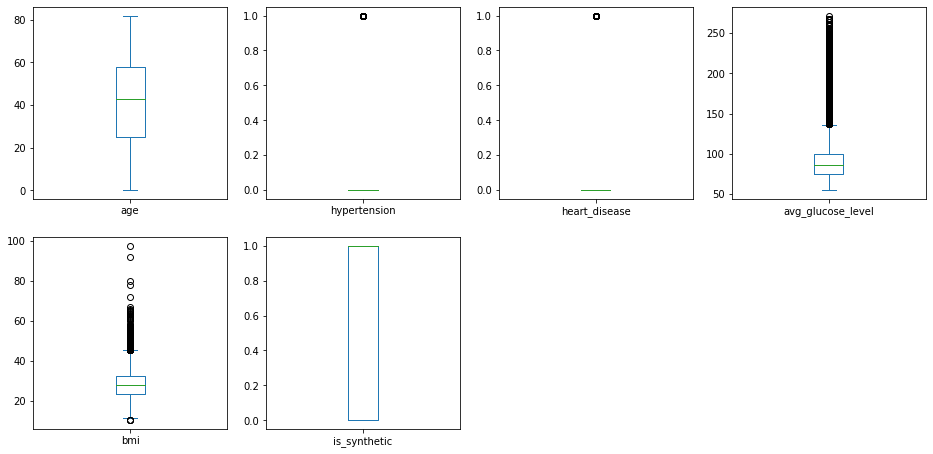

In [25]:
# Box and Whisker plot for each attribute
df_features_train.plot(kind='box', subplots=True, layout=(display_rows, display_columns))
plt.show()

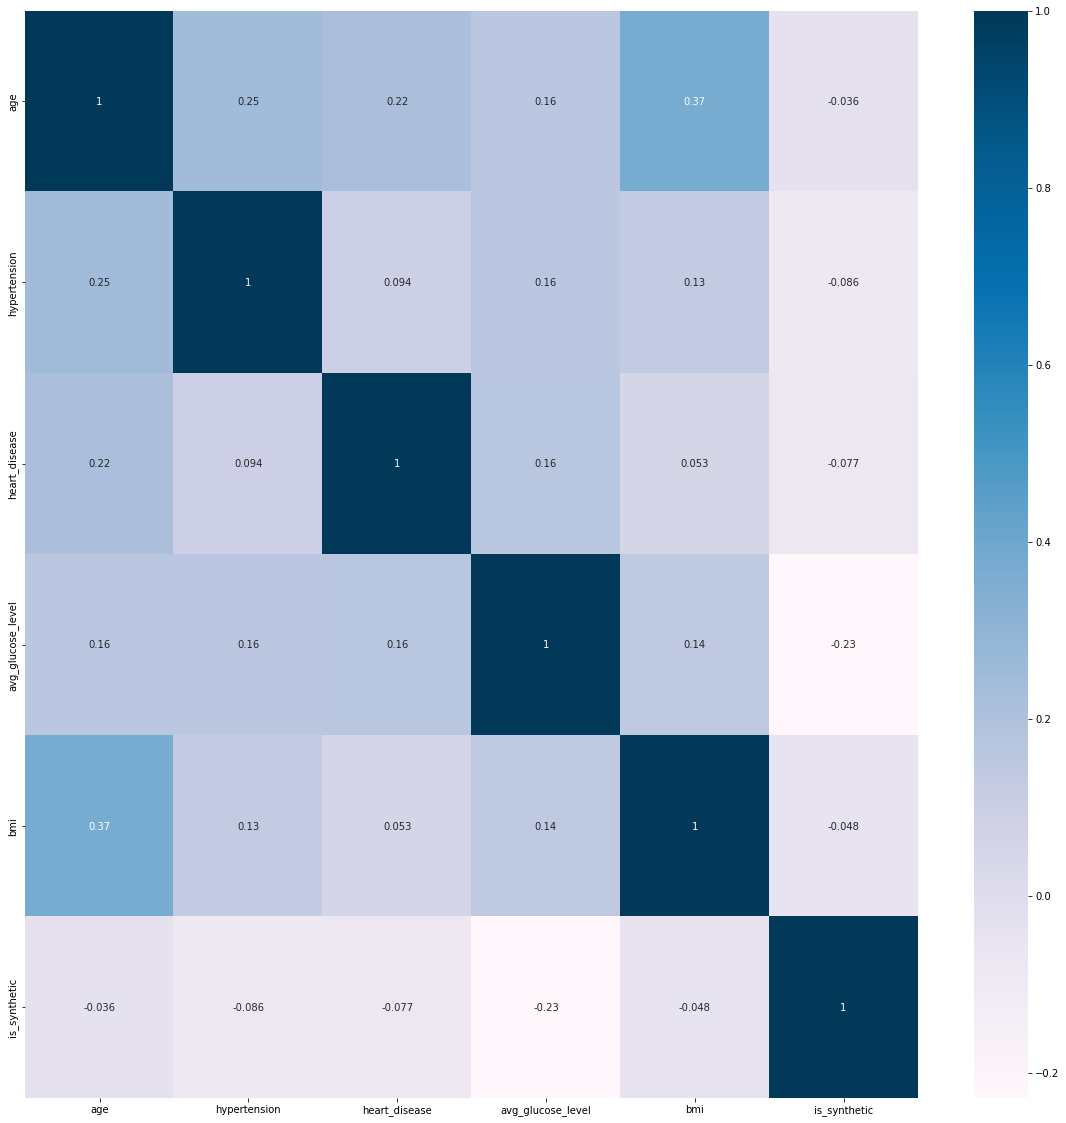

In [26]:
# Correlation matrix
fig = plt.figure(figsize=(20, 20))
correlations = df_features_train.corr(method='pearson')
sns.heatmap(correlations, annot=True, cmap=plt.cm.PuBu)
plt.show()

In [27]:
if NOTIFY_STATUS: status_notify("Task 2 - Summarize and Visualize Data completed! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 3 - Pre-process Data

In [28]:
if NOTIFY_STATUS: status_notify("Task 3 - Pre-process Data has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 3.a) Feature Scaling and Data Pre-Processing

In [29]:
# Compose pipeline for the numerical and categorical features (Block #1 of 2)
numeric_columns = df_features_train.select_dtypes(include=['float','int']).columns
numeric_transformer = Pipeline(steps=[
    ('imputer', impute.SimpleImputer(strategy="median")),
    ('scaler', preprocessing.StandardScaler())
])
categorical_columns = df_features_train.select_dtypes(include=['object','bool','category']).columns
categorical_transformer = Pipeline(steps=[
    ('imputer', impute.SimpleImputer(strategy='constant', fill_value='UKNOWN')),
    ('onehot', preprocessing.OneHotEncoder(sparse=False, handle_unknown='ignore'))
])

print("Number of numerical columns:", len(numeric_columns))
print("Number of categorical columns:", len(categorical_columns))
print("Total number of columns in the feature dataframe:", df_features_train.shape[1])

Number of numerical columns: 6
Number of categorical columns: 5
Total number of columns in the feature dataframe: 11


In [30]:
# Compose pipeline for the numerical and categorical features (Block #2 of 2)
preprocessor = compose.ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_columns),
    ('cat', categorical_transformer, categorical_columns)
], remainder='passthrough')

In [31]:
# Finalize the training dataset for the modeling activities
array_features_train = preprocessor.fit_transform(df_features_train)
# array_features_train = df_features_train.to_numpy()
label_encoder = preprocessing.LabelEncoder()
array_target_train = label_encoder.fit_transform(df_target_train)

### 3.b) Training Data Balancing

In [32]:
# Perform SMOTE transformation on the training data (Block #1 of 2)
X_train_imbal = array_features_train
y_train_imbal = array_target_train
print("X_train_imbal.shape: {} y_train_imbal.shape: {}".format(X_train_imbal.shape, y_train_imbal.shape))

X_train_imbal.shape: (20414, 20) y_train_imbal.shape: (20414,)


In [33]:
# Perform SMOTE transformation on the training data (Block #2 of 2)
print ('Original class distribution - 1: {} | 0: {}'.format((array_target_train==1).sum(), (array_target_train==0).sum()))
# over_sample = SMOTE(sampling_strategy=0.5, random_state=RNG_SEED)
under_sample = RandomUnderSampler(sampling_strategy=0.10, random_state=RNG_SEED)
# steps = [('o', over_sample), ('u', under_sample)]
steps = [('u', under_sample)]
sample_pipeline = Pipeline(steps=steps)
array_features_train, array_target_train = sample_pipeline.fit_resample(X_train_imbal, y_train_imbal)
print ('Resampled class distribution - 1: {} | 0: {}'.format((array_target_train==1).sum(), (array_target_train==0).sum()))

Original class distribution - 1: 881 | 0: 19533
Resampled class distribution - 1: 881 | 0: 8810


### 3.c) Feature Selection

In [34]:
# Not applicable for this iteration of modeling

### 3.d) Display the Final Datasets for Model-Building

In [35]:
# Finalize the training dataset for the modeling activities
# array_features_train = preprocessor.fit_transform(df_features_train)
# array_features_train = df_features_train.to_numpy()
# label_encoder = preprocessing.LabelEncoder()
# array_target_train = label_encoder.fit_transform(df_target_train)
print("array_features_train.shape: {} array_target_train.shape: {}".format(array_features_train.shape, array_target_train.shape))

array_features_train.shape: (9691, 20) array_target_train.shape: (9691,)


In [36]:
if NOTIFY_STATUS: status_notify("Task 3 - Pre-process Data completed! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 4 - Train and Tune Models

In [37]:
if NOTIFY_STATUS: status_notify("Task 4 - Train and Tune Models has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 4.a) Set test options and evaluation metric

In [38]:
# Set up Algorithms Spot-Checking Array
start_time_training = datetime.now()
train_models = []
train_results = []
train_model_names = []
train_metrics = []

In [39]:
train_models.append(('LGR', LogisticRegression(random_state=RNG_SEED, solver='lbfgs', n_jobs=N_JOBS)))
train_models.append(('CART', DecisionTreeClassifier(random_state=RNG_SEED)))
train_models.append(('KNN', KNeighborsClassifier(n_jobs=N_JOBS)))
train_models.append(('BGT', BaggingClassifier(random_state=RNG_SEED, n_jobs=N_JOBS)))
train_models.append(('RNF', RandomForestClassifier(random_state=RNG_SEED, n_jobs=N_JOBS)))
train_models.append(('EXT', ExtraTreesClassifier(random_state=RNG_SEED, n_jobs=N_JOBS)))

In [40]:
# Generate model in turn
for name, model in train_models:
	if NOTIFY_STATUS: status_notify("Algorithm", name, "modeling has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))
	start_time_module = datetime.now()
	kfold = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RNG_SEED)
	cv_results = cross_val_score(model, array_features_train, array_target_train, cv=kfold, scoring=SCORING_METRIC, n_jobs=N_JOBS, verbose=1)
	train_results.append(cv_results)
	train_model_names.append(name)
	train_metrics.append(cv_results.mean())
	print("%s: %f (%f)" % (name, cv_results.mean(), cv_results.std()))
	print(model)
	print ('Model training time:', (datetime.now() - start_time_module), '\n')
	if NOTIFY_STATUS: status_notify("Algorithm", name, "modeling completed! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))
print ('Average metrics (' + SCORING_METRIC + ') from all models:', np.mean(train_metrics))
print ('Total training time for all models:', (datetime.now() - start_time_training))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit

LGR: 0.873508 (0.015835)
LogisticRegression(n_jobs=1, random_state=888)
Model training time: 0:00:07.092137 



[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


CART: 0.620437 (0.024473)
DecisionTreeClassifier(random_state=888)
Model training time: 0:00:00.771738 



[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    5.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


KNN: 0.739169 (0.036850)
KNeighborsClassifier(n_jobs=1)
Model training time: 0:00:05.062155 



[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    5.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


BGT: 0.807226 (0.019592)
BaggingClassifier(n_jobs=1, random_state=888)
Model training time: 0:00:05.118259 



[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   13.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


RNF: 0.846044 (0.018454)
RandomForestClassifier(n_jobs=1, random_state=888)
Model training time: 0:00:13.325170 

EXT: 0.815560 (0.021188)
ExtraTreesClassifier(n_jobs=1, random_state=888)
Model training time: 0:00:06.532738 

Average metrics (roc_auc) from all models: 0.7836571634189334
Total training time for all models: 0:00:37.964509


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    6.5s finished


### 4.b) Spot-checking baseline algorithms

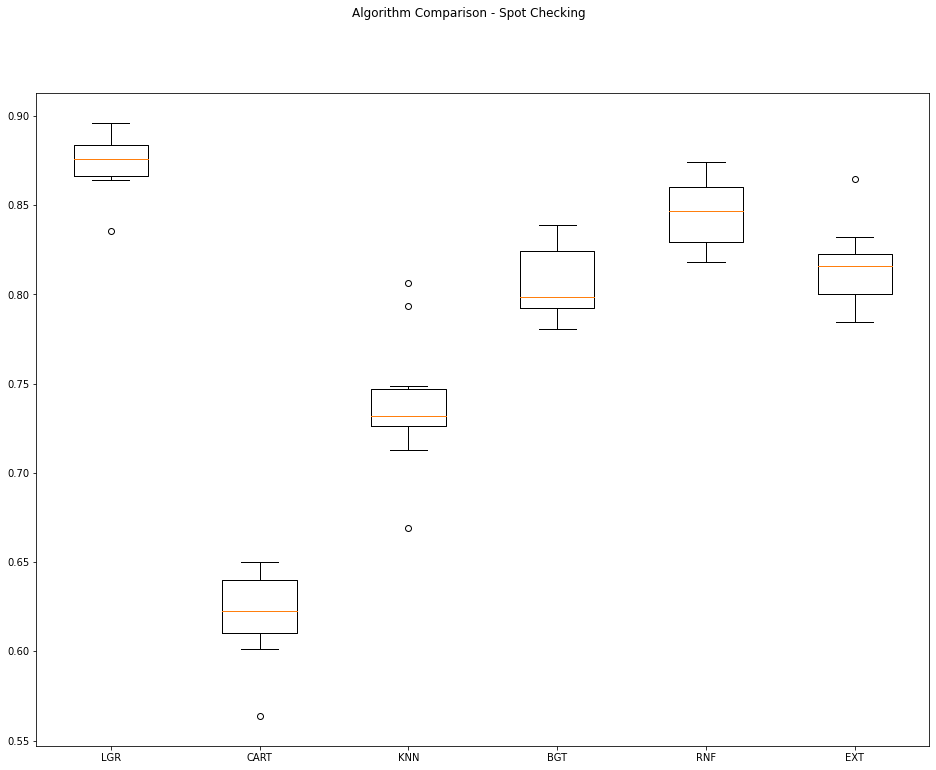

In [41]:
fig = plt.figure(figsize=(16,12))
fig.suptitle('Algorithm Comparison - Spot Checking')
ax = fig.add_subplot(111)
plt.boxplot(train_results)
ax.set_xticklabels(train_model_names)
plt.show()

In [42]:
if NOTIFY_STATUS: status_notify("Task 4 - Train and Tune Models completed! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 4.c) Algorithm Tuning

In [43]:
# Set up the comparison array
tune_results = []
tune_model_names = []

In [44]:
# Tuning algorithm #1
start_time_module = datetime.now()
if NOTIFY_STATUS: status_notify("Algorithm #1 tuning has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

tune_model1 = RandomForestClassifier(random_state=RNG_SEED, n_jobs=N_JOBS)
tune_model_names.append('RNF')
paramGrid1 = dict(n_estimators=np.array([100, 300, 500]))

kfold = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RNG_SEED)
grid1 = GridSearchCV(estimator=tune_model1, param_grid=paramGrid1, scoring=SCORING_METRIC, cv=kfold, n_jobs=N_JOBS, verbose=1)
grid_result1 = grid1.fit(array_features_train, array_target_train)

print("Best: %f using %s" % (grid_result1.best_score_, grid_result1.best_params_))
tune_results.append(grid_result1.cv_results_['mean_test_score'])
means = grid_result1.cv_results_['mean_test_score']
stds = grid_result1.cv_results_['std_test_score']
params = grid_result1.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
print ('Model training time:', (datetime.now() - start_time_module))
if NOTIFY_STATUS: status_notify("Algorithm #1 tuning completed! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

Fitting 10 folds for each of 3 candidates, totalling 30 fits
Best: 0.852394 using {'n_estimators': 500}
0.846044 (0.018454) with: {'n_estimators': 100}
0.851878 (0.015348) with: {'n_estimators': 300}
0.852394 (0.015376) with: {'n_estimators': 500}
Model training time: 0:01:18.759066


In [45]:
best_paramKey1 = list(grid_result1.best_params_.keys())[0]
best_paramValue1 = list(grid_result1.best_params_.values())[0]
print("Captured the best parameter for algorithm #1:", best_paramKey1, '=', best_paramValue1)

Captured the best parameter for algorithm #1: n_estimators = 500


In [46]:
# Tuning algorithm #2
start_time_module = datetime.now()
if NOTIFY_STATUS: status_notify("Algorithm #2 tuning has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

tune_model2 = BaggingClassifier(random_state=RNG_SEED, n_jobs=N_JOBS)
tune_model_names.append('BGT')
paramGrid2 = dict(n_estimators=np.array([10, 20, 30]))

kfold = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RNG_SEED)
grid2 = GridSearchCV(estimator=tune_model2, param_grid=paramGrid2, scoring=SCORING_METRIC, cv=kfold, n_jobs=N_JOBS, verbose=1)
grid_result2 = grid2.fit(array_features_train, array_target_train)

print("Best: %f using %s" % (grid_result2.best_score_, grid_result2.best_params_))
tune_results.append(grid_result2.cv_results_['mean_test_score'])
means = grid_result2.cv_results_['mean_test_score']
stds = grid_result2.cv_results_['std_test_score']
params = grid_result2.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
print ('Model training time:', (datetime.now() - start_time_module))
if NOTIFY_STATUS: status_notify("Algorithm #2 tuning completed! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

Fitting 10 folds for each of 3 candidates, totalling 30 fits
Best: 0.843325 using {'n_estimators': 30}
0.807226 (0.019592) with: {'n_estimators': 10}
0.834101 (0.019208) with: {'n_estimators': 20}
0.843325 (0.017078) with: {'n_estimators': 30}
Model training time: 0:00:15.569575


In [47]:
best_paramKey2 = list(grid_result2.best_params_.keys())[0]
best_paramValue2 = list(grid_result2.best_params_.values())[0]
print("Captured the best parameter for algorithm #2:", best_paramKey2, '=', best_paramValue2)

Captured the best parameter for algorithm #2: n_estimators = 30


### 4.d) Compare Algorithms After Tuning

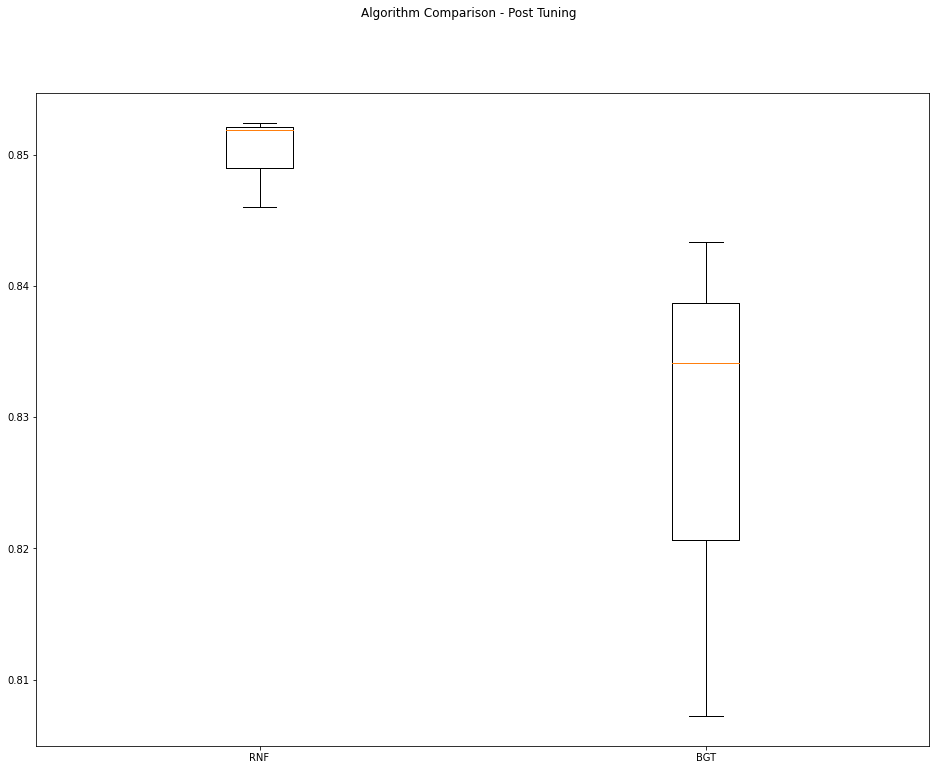

In [48]:
fig = plt.figure(figsize=(16,12))
fig.suptitle('Algorithm Comparison - Post Tuning')
ax = fig.add_subplot(111)
plt.boxplot(tune_results)
ax.set_xticklabels(tune_model_names)
plt.show()

In [49]:
if NOTIFY_STATUS: status_notify("Task 4 - Train and Tune Models completed! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 5 - Finalize Model and Make Predictions

In [50]:
if NOTIFY_STATUS: status_notify("Task 5 - Finalize Model and Make Predictions has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 5.a) Train the Final Model

In [51]:
final_model = LogisticRegression(random_state=RNG_SEED, solver='lbfgs', n_jobs=N_JOBS)
final_model.fit(array_features_train, array_target_train)
print(final_model)

LogisticRegression(n_jobs=1, random_state=888)


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### 5.b) Load Test Dataset and Make Predictions

In [52]:
df_features_test = pd.read_csv(TEST_DATASET)
df_features_test['is_synthetic'] = 1

# Fill in some missing fields with the most common values
df_features_test['gender'] = df_features_test['gender'].apply(clean_gender)
df_features_test['smoking_status'] = df_features_test['smoking_status'].apply(clean_smoking_status)

# Take a peek at the dataframe after import
print(df_features_test.head())

      id  gender   age  hypertension  heart_disease ever_married work_type  \
0  15304  Female  57.0             0              0          Yes   Private   
1  15305    Male  70.0             1              0          Yes   Private   
2  15306  Female   5.0             0              0           No  children   
3  15307  Female  56.0             0              0          Yes  Govt_job   
4  15308    Male  32.0             0              0          Yes   Private   

  Residence_type  avg_glucose_level   bmi smoking_status  is_synthetic  
0          Rural              82.54  33.4   never smoked             1  
1          Urban              72.06  28.5   never smoked             1  
2          Urban             103.72  19.5   never smoked             1  
3          Urban              69.24  41.4         smokes             1  
4          Rural             111.15  30.1         smokes             1  


In [53]:
df_features_test.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10204 entries, 0 to 10203
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 10204 non-null  int64  
 1   gender             10204 non-null  object 
 2   age                10204 non-null  float64
 3   hypertension       10204 non-null  int64  
 4   heart_disease      10204 non-null  int64  
 5   ever_married       10204 non-null  object 
 6   work_type          10204 non-null  object 
 7   Residence_type     10204 non-null  object 
 8   avg_glucose_level  10204 non-null  float64
 9   bmi                10204 non-null  float64
 10  smoking_status     10204 non-null  object 
 11  is_synthetic       10204 non-null  int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 956.8+ KB


In [54]:
id_column_name = df_features_test.columns[0]
df_kaggle_submission = pd.DataFrame()
df_kaggle_submission[id_column_name] = df_features_test[id_column_name]
print(df_kaggle_submission.head())

      id
0  15304
1  15305
2  15306
3  15307
4  15308


In [55]:
# Dropping unique identifier and unnecessary features
df_features_test.drop(columns=[id_column_name,], inplace=True)

# Take a peek at the dataframe after cleaning
print(df_features_test.head())

   gender   age  hypertension  heart_disease ever_married work_type  \
0  Female  57.0             0              0          Yes   Private   
1    Male  70.0             1              0          Yes   Private   
2  Female   5.0             0              0           No  children   
3  Female  56.0             0              0          Yes  Govt_job   
4    Male  32.0             0              0          Yes   Private   

  Residence_type  avg_glucose_level   bmi smoking_status  is_synthetic  
0          Rural              82.54  33.4   never smoked             1  
1          Urban              72.06  28.5   never smoked             1  
2          Urban             103.72  19.5   never smoked             1  
3          Urban              69.24  41.4         smokes             1  
4          Rural             111.15  30.1         smokes             1  


In [56]:
# Finalize the test dataset for the testing activities
array_features_test = preprocessor.transform(df_features_test)
print("Transformed features from df_features_test.shape: {} to array_features_test.shape: {}".format(df_features_test.shape, array_features_test.shape))

Transformed features from df_features_test.shape: (10204, 11) to array_features_test.shape: (10204, 20)


In [57]:
# Make batched predictions
test_predictions =  final_model.predict_proba(array_features_test)
print(test_predictions)

[[0.9125494  0.0874506 ]
 [0.71603056 0.28396944]
 [0.99830021 0.00169979]
 ...
 [0.9985448  0.0014552 ]
 [0.99185326 0.00814674]
 [0.99894393 0.00105607]]


In [58]:
df_sample_submission = pd.read_csv(SUBMISSION_TEMPLATE)
df_sample_submission.drop(columns=[id_column_name], inplace=True)
submission_header = list(df_sample_submission.columns)[0]
print(submission_header)

stroke


In [59]:
df_kaggle_submission[submission_header] = test_predictions[:,1]
print(df_kaggle_submission.head())

      id    stroke
0  15304  0.087451
1  15305  0.283969
2  15306  0.001700
3  15307  0.113122
4  15308  0.016301


In [60]:
submission_file = df_kaggle_submission.to_csv(header=True, index=False)
filename = SUBMISSION_FILE + datetime.now().strftime('%Y%m%d-%H%M') + '.csv'
with open(filename, 'w') as f:
    f.write(submission_file)
    print('Completed writing output file: ' + filename)

Completed writing output file: submission_sklearn_20230122-2317.csv


In [61]:
if NOTIFY_STATUS: status_notify("Task 5 - Finalize Model and Make Predictions completed! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [62]:
print ('Total time for the script:',(datetime.now() - START_TIME_SCRIPT))

Total time for the script: 0:02:22.733561
